# **Illustrative example of `CLUE` for a model in ODEBase**

In this notebook we present an example of applying CLUE for a model in [ODEBase](https://www.odebase.org/table/) (`BIOMD0000000102`) and how we can easily use `CLUE` to compute system reductions on the models.
If this is the first time running CLUE or you are running it on an online instance, first install the latest version of CLUE by running the following line.

In [ ]:
%pip install git+https://github.com/clue-developers/CLUE

In [1]:
from clue import *

#### **Loading the dynamical system**

First, we can use the interface of `ode_scrapper` to get the dynamical system directly from the website. Since `CLUE` treats parameters as differential variables, we remove them with the method `remove_parameters_ic`:

In [2]:
model = ode_scrapper(name="BIOMD0000000102")
model = model.remove_parameters_ic()

We can now check the content of our model

In [3]:
print(model.name)  # Outputs the name of the model
print(model.size)  # Outputs the size of the model
print(model.species)  # Lists the biological species
print(model.pars)  # Displays the model parameters 
print(model.equations)  # Shows the model equations

ODEBase 1402 (BIOMD0000000102)_evaluated
13
['x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9', 'x10', 'x11', 'x12', 'x13']
[]
[1/50 + 1/10*x12 + 1/10*x6 + 1/10*x5 + 1/10*x13 - 1/1000*x1 - 1/500*x1*x2 - 1/500*x1*x3 - 1/500*x1*x10 - 1/500*x1*x11, 1/50 + 1/1000*x3 + 1/10*x6 - 1/1000*x2 - 1/500*x1*x2 - 1/1000*x2*x4 - 1/5000*x2*x8, 1/10*x5 - 1/500*x3 + 1/1000*x2*x4 - 1/500*x1*x3, 1/25 + 1/1000*x3 + 1/1000*x5 + 1/1000*x10 + 1/1000*x13 + 1/1000*x9 - 1/1000*x4 - 1/1000*x2*x4 - 1/1000*x4*x6 - 1/1000*x4*x11 - 1/1000*x4*x12 - 3/1000*x4*x8, -51/500*x5 + 1/1000*x4*x6 + 1/500*x1*x3, 1/1000*x5 - 101/1000*x6 + 1/500*x1*x2 - 1/1000*x4*x6 - 1/5000*x6*x8, 1/5 - 1/1000*x7 - 1/200000*x2*x7 - 7/20000*x6*x7 - 1/20000*x7*x11 - 7/2000*x7*x12, 1/1000*x9 - 1/1000*x8 + 1/200000*x2*x7 + 7/20000*x6*x7 + 1/20000*x7*x11 + 7/2000*x7*x12 - 3/1000*x4*x8, -1/500*x9 + 3/1000*x4*x8, 1/10*x13 - 1/500*x10 + 1/1000*x4*x11 - 1/500*x1*x10, 1/10*x12 + 1/1000*x10 - 1/1000*x11 + 1/5000*x2*x8 - 1/1000*x4*x11 - 1/500*x1*x11, 1/1

#### **Setting up initial condition on the differential system**

Currently, the module `odebase_io` do not load the initial conditions for the system since they are not included in the database. However, we can create these initial conditions by providing a dictionary with the initial conditions:

In [4]:
# Initial conditions from the paper
init_cond = {}
init_cond['x1'] = 20
init_cond['x2'] = 20
init_cond['x4'] = 40
init_cond['x7'] = 200

# Adding initial conditions (filling missing entries with zeros)
model.set_ic(init_cond, fill=True)

#### **Computing different lumpings**

##### *Exact lumping*

We now proceed to compute the exact lumping w.r.t. the variable `x7`:

In [5]:
exact_lump = model.lumping(['x7'])

2024-05-06 13:48:31 WARNING  [lumping] lumped size (13) and original size (13) are the same.


We can appreciate with the given warning that this exact lumping could not reduced the model. Hence, we proceed to use numerical lumping to try and reduce it a bit further.

##### *Numerical lumping*

In [6]:
app_lump_1 = model.app_lumping(['x7'])
app_lump_1.size

12

This numerical lumping has size 12. This is not a big reduction. We can ask `CLUE` to provide even a further reduction using approximate `CLUE` by setting a maximal size for the reduction:

In [7]:
app_lump_2 = model.app_lumping(['x7'], max_size=10)
app_lump_2.size

9

#### **Simulating dynamical systems**

`CLUE` also offer methods to simulate dynamical systems with given initial conditions. We can use this method (`simulate`) to see how much error we have made while computing the two approximate reductions:

In [8]:
# Simulate the system with the previous initial conditions
exact_sim = model.simulate(0, 2500, view=["x7"])
app_sim_1 = app_lump_1.simulate(0, 2500, view=app_lump_1.observe(["x7"]))
app_sim_2 = app_lump_2.simulate(0, 2500, view=app_lump_2.observe(["x7"]))

In this three simulations, we have the value for `x7` represented in the exact dynamical system (imported from the web) and the two approximate lumpings we have already computed (with dimensions 12 and 7). We can now display this using the method `create_figure` after merging these three simulations:

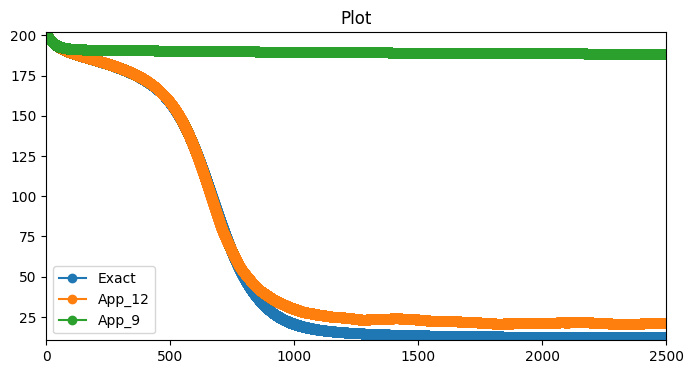

In [9]:
# Merge simulation results and plot them
merged = merge_simulations(exact_sim, app_sim_1, app_sim_2) 
create_figure(merged, names=['Exact', 'App_12', 'App_9']);